In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.colors import to_rgb
from matplotlib.colors import LinearSegmentedColormap


/Users/tobias/opt/anaconda3/envs/neuralODE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/lk/x8186w8j3_s9plr83dmmwnm00000gn/T/ipykernel_47140/1868336090.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(all_labels, dtype=torch.float32).unsqueeze(dim=1)


379
torch.Size([758, 1])


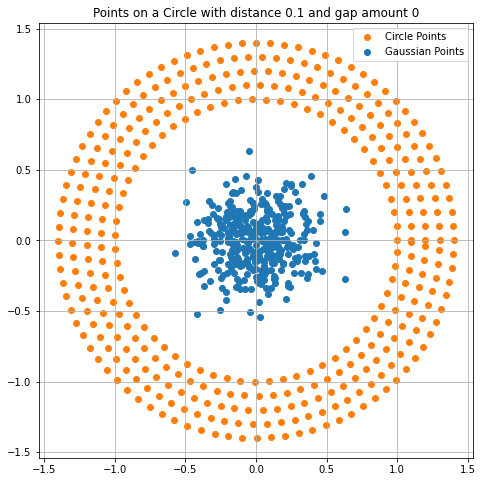

In [3]:
def generate_circle_points(radius, eps, gap_amount, dtype=torch.float32, label_type=torch.int64):
    """
    Generates points on a circle of given radius with a minimum distance between points.

    Args:
        radius (float): Radius of the circle.
        eps (float): Minimum Euclidean distance between points.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = []
    angle_step = 2 * np.arcsin(eps / (2 * radius))  # Approximation for minimum angle

    angle = 0.0
    while angle < 2 * np.pi - gap_amount*angle_step:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
        angle += angle_step

    points = torch.tensor(points, dtype=dtype)
    labels = torch.ones(points.size(0), dtype=label_type)  # Assign label 1 to all points

    return points, labels

def generate_gaussian_points(count, mean, std_dev, dtype=torch.float32, label_type=torch.int64):
    """
    Generates Gaussian-distributed points around a given mean with standard deviation.

    Args:
        count (int): Number of points to generate.
        mean (float): Mean value for Gaussian distribution.
        std_dev (float): Standard deviation for Gaussian distribution.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = torch.normal(mean=mean, std=std_dev, size=(count, 2), dtype=dtype)
    labels = torch.zeros(count, dtype=label_type)  # Assign label 0 to all points

    return points, labels

# Parameters for the circle
radii = [1.,1.1,1.2,1.3,1.4]
epsilon = 0.1
gap_amount = 0

# Generate the dataset for the circle
circle_points_all = torch.zeros(0, dtype=torch.float32)
circle_labels_all = torch.ones(0, dtype=torch.int64)  # Assign label 1 to all points

for radius in radii:
    circle_points, circle_labels = generate_circle_points(radius, epsilon, gap_amount = gap_amount)
    circle_points_all = torch.cat((circle_points_all, circle_points), dim=0)
    circle_labels_all = torch.cat((circle_labels_all, circle_labels), dim=0)        
    

# Generate Gaussian-distributed points
num_gaussian_points = circle_points_all.size(0)
print(num_gaussian_points)
mean = 0.0
std_dev = 0.2
gaussian_points, gaussian_labels = generate_gaussian_points(num_gaussian_points, mean, std_dev)

# Combine datasets
all_points = torch.cat((circle_points_all, gaussian_points), dim=0)
all_labels = torch.cat((circle_labels_all, gaussian_labels), dim=0)
labels_tensor = torch.tensor(all_labels, dtype=torch.float32).unsqueeze(dim=1)
print(labels_tensor.size())


# Plot the points
plt.figure(figsize=(8, 8))
plt.scatter(circle_points_all[:, 0].numpy(), circle_points_all[:, 1].numpy(), color='C1', label='Circle Points')
plt.scatter(gaussian_points[:, 0].numpy(), gaussian_points[:, 1].numpy(), color='C0', label='Gaussian Points')
plt.title(f'Points on a Circle with distance {epsilon} and gap amount {gap_amount}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()

batch_size = 20

# Create a DataLoader
dataset = TensorDataset(all_points, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            # nn.Linear(dim, dim)
        )
        # self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.fc(x)
        out = out + identity
        # out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=2, num_blocks=5, num_classes=1): #num_classes = 2
        super(ResNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x



Epoch [1/200], Loss: 0.7215
Epoch [20/200], Loss: 0.0305
Epoch [40/200], Loss: 0.0049
Epoch [60/200], Loss: 0.0019
Epoch [80/200], Loss: 0.0011
Epoch [100/200], Loss: 0.0006
Epoch [120/200], Loss: 0.0004
Epoch [140/200], Loss: 0.0011
Epoch [160/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0003
Accuracy: 50.00%


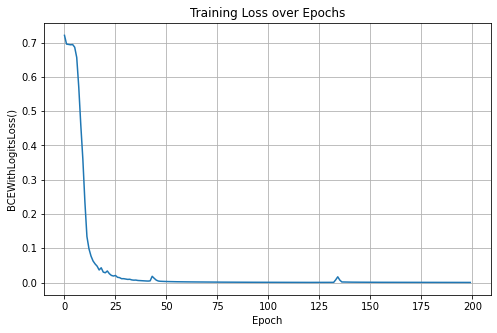

In [5]:

# Initialize the model, loss function, and optimizer
model = ResNet()
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


losses = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')
    losses.append(total_loss / len(dataloader))

# Evaluate the trained model
model.eval()
with torch.no_grad():
    predictions = model(all_points)
    predicted_classes = torch.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = (torch.abs(predicted_classes - all_labels)<0.01).float().mean().item()
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel(f'{criterion}')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()



In [6]:
print(predicted_classes[:200])
print(torch.sigmoid(predictions)[:20])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
   

In [7]:
model.parameters
criterion

BCEWithLogitsLoss()

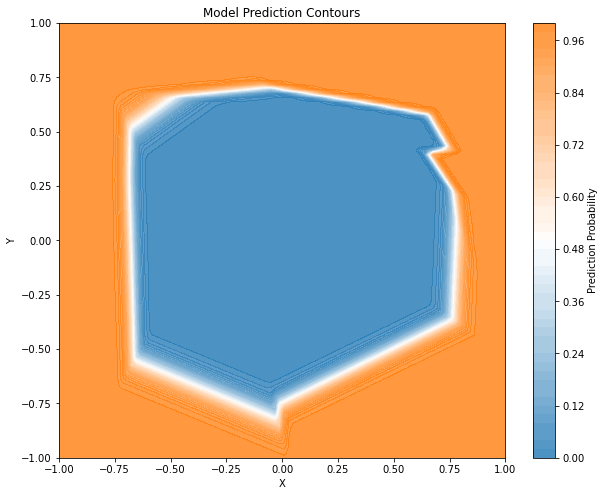

In [8]:
# Plot prediction contours
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    zz = torch.sigmoid(model(grid)[:,0]).reshape(xx.shape).numpy()

colors = [to_rgb("C0"), [1, 1, 1], to_rgb("C1")] # first color is orange, last is blue
cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, zz, levels=50, cmap=cm, alpha=0.8)
plt.colorbar(label='Prediction Probability')
plt.xlabel('X')
plt.ylabel('Y')
# plt.scatter(ring_points[:500, 0], ring_points[:500, 1], s=25, facecolors='C1', edgecolors='black', linewidths=0.5, alpha=0.5)
# plt.scatter(inside_points[:500, 0], inside_points[:500, 1], s=25, c='C0',  edgecolors='black', linewidths=0.5, alpha=0.5,  label='Inside Points')
plt.title('Model Prediction Contours')
# plt.axis('equal')
plt.grid(False)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('tight')
plt.show()